# AllLife Credit Card Customer Segmentation
## Background:
AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalised campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customers queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help.

## Objective: 
To identify different segments in the existing customer based on their spending patterns as well as past interaction with the bank.

## Key Questions:
How many different segments of customers are there? 
How are these segments different from each other?
What are your recommendations to the bank on how to better market to and service these customers?

## Variable Description:
Customer key - Identifier for the customer
<br> Average Credit Limit - Average credit limit across all the credit cards
<br> Total credit cards - Total number of credit cards
<br> Total visits bank - Total number of bank visits
<br> Total visits online - total number of online visits
<br> Total calls made - Total number of calls made by the customer


# EDA

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)
from matplotlib import pyplot as plt
from scipy.spatial.distance import pdist
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering 
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage

In [2]:
df = pd.read_excel('Credit Card Customer Data (1).xlsx')
df.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [3]:
#This is a small dataset, only 660 values
#They are all of type int64
'''The mean and standard deviation values are quite different from one feature to another. Hence, 
    scaling must be done before clustering'''
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000
mean,330.500000,55141.443939,34574.242424,4.706061,2.403030,2.606061,3.583333
std,190.669872,25627.772200,37625.487804,2.167835,1.631813,2.935724,2.865317
min,1.000000,11265.000000,3000.000000,1.000000,0.000000,0.000000,0.000000
25%,165.750000,33825.250000,10000.000000,3.000000,1.000000,1.000000,1.000000
50%,330.500000,53874.500000,18000.000000,5.000000,2.000000,2.000000,3.000000
75%,495.250000,77202.500000,48000.000000,6.000000,4.000000,4.000000,5.000000
max,660.000000,99843.000000,200000.000000,10.000000,5.000000,15.000000,10.000000


In [4]:
#There are no null values in this dataset
df.isnull().any()

Sl_No                  False
Customer Key           False
Avg_Credit_Limit       False
Total_Credit_Cards     False
Total_visits_bank      False
Total_visits_online    False
Total_calls_made       False
dtype: bool

In [5]:
#It seems there are no duplicates in this dataset as well
duplicateRowsDF = df[df.duplicated()]
duplicateRowsDF.shape

(0, 7)

In [6]:
#We drop the 'SI_No' column since it is basically a redundant index column
df = df.drop(['Sl_No'], axis=1)

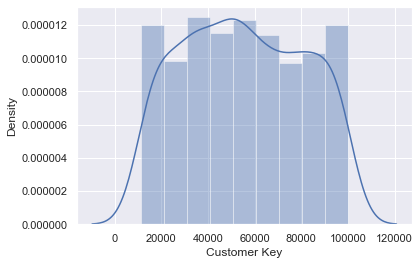

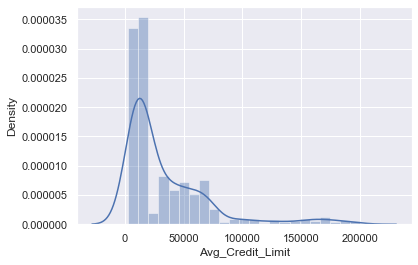

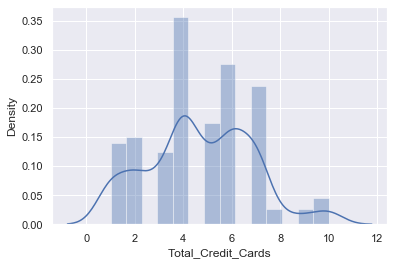

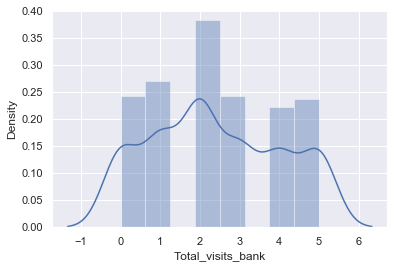

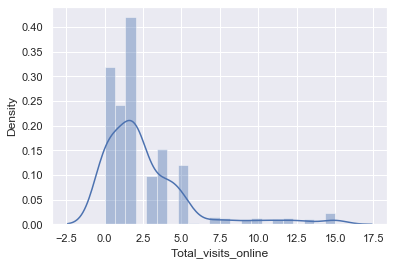

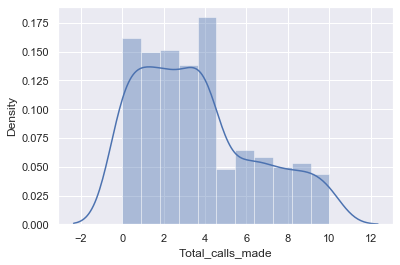

In [7]:
#From these plots, it seems that we may need a minimum of 2 clusters
#This is because we can see peaks across most if not all variables
import warnings
warnings.filterwarnings('ignore')
for i in df.columns:
    sns.distplot(df[i])
    plt.show()

Insights: The distribution for customer keys is nearly uniformly distributed, although this feature does not tell us much and thus will be dropped. The average credit limit is skewed right, most obsersvations lay around 30000 or so. The total number of credit cards variable varies highly, although most people seem to have around 4 credit cards. The total number of visits to the bank also seems to vary quite a bit. The total visits online variable is skewed right. It seems to have around the same distribution as number of bank visits. The total calls made is slightly right skewed as well as most people seem to have made 0 to 5 calls.

<n> Based on these plots, I am beginning to see potential clusters that can be formed. The average credit limit and the total number of credit cards used are both right skewed. Clusters could form corresponding to the peaks of these distributions. The total number of credit cards, total number of visits to the bank, and the total number of calls made may be tougher to cluster with since they are more uniformly distributed. Based on the number of peaks I see across all variables, I am thinking that around 4 clusters may be ideal for this analysis. Just to be sure, the elbow method will be implemented.

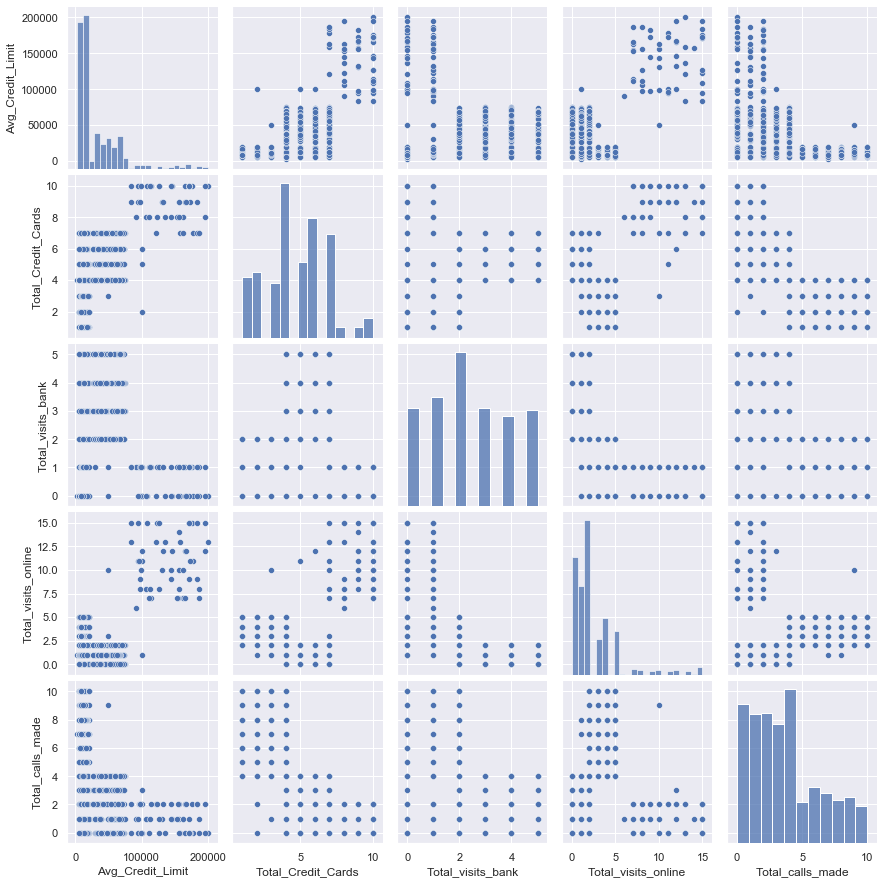

In [8]:
#Here we can see that the average credit limit and total credit cards used are slighly positively correlated
#The distribution for avg_credit limit and total visits online are right skewed
#I choose to keep the rest of the variables in the analysis
#For the most part, it seems that a majority of the variables are independent from one another
    #with low correlation coefficients
#To quantify the correlation between these variables, a heatmap will be created a few steps later
df = df.drop(['Customer Key'], axis=1)
sns.pairplot(df)

In [9]:
#Now, let us take a closer look at the discrete numerical variables
#It seems that most people have either 4,6, or 7 credit cards
#This will be of use to the clustering model due to its high variability
df.groupby(['Total_Credit_Cards']).count()['Avg_Credit_Limit']

Total_Credit_Cards
1      59
2      64
3      53
4     151
5      74
6     117
7     101
8      11
9      11
10     19
Name: Avg_Credit_Limit, dtype: int64

In [10]:
#This variable is somewhat evenly distributed. The number of visits to the bank may not add much to 
    #the clustering model due to this
#However, since we are working with only a small amount of features, I will leave it in the analysis
df.groupby(['Total_visits_bank']).count()['Avg_Credit_Limit']

Total_visits_bank
0    100
1    112
2    158
3    100
4     92
5     98
Name: Avg_Credit_Limit, dtype: int64

In [11]:
#This variable will also be of use in the clustering algorithm due to its high variability
#Most customers visited the bank's website a few times only
df.groupby(['Total_visits_online']).count()['Avg_Credit_Limit']

Total_visits_online
0     144
1     109
2     189
3      44
4      69
5      54
6       1
7       7
8       6
9       4
10      6
11      5
12      6
13      5
14      1
15     10
Name: Avg_Credit_Limit, dtype: int64

In [12]:
#There is moderate variability in this variable. Customers tend to call between 0 and 5 times for the most part
#This may be a good variable to cluster with due to its moderate variability
df.groupby(['Total_calls_made']).count()['Avg_Credit_Limit']

Total_calls_made
0      97
1      90
2      91
3      83
4     108
5      29
6      39
7      35
8      30
9      32
10     26
Name: Avg_Credit_Limit, dtype: int64

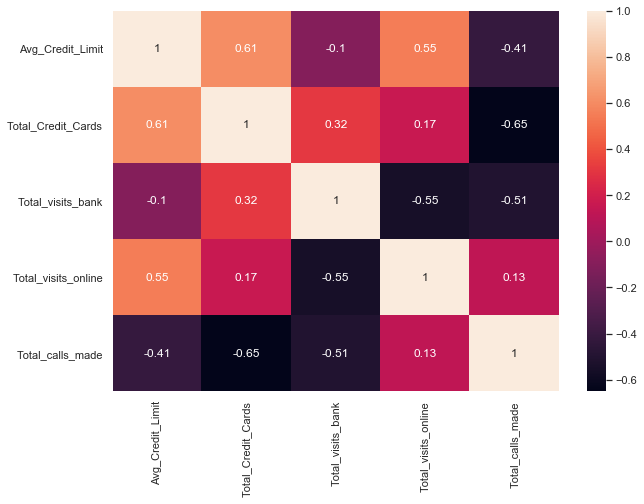

In [13]:
#There seems to be a moderately strong positive relationship between the average credit limit and the total number
    #of credit cards a customer carries
#There is also a moderately strong positive relationship between the total number of visits online and the average 
    #credit limit
#There is a moderately strong negative relationship between the total number of calls made and the 
    #total number of credit cards used. 
corr = df.corr()
fig, ax = plt.subplots(figsize=(10,7)) 
sns.heatmap(corr, annot = True)

# K-Means Clustering

In [14]:
#Before I cluster, I must standardize the data since we observed that the scales for each variable 
    #differ considerably
#I use z-score to standardize the dataset. Now, the data is ready for the clustering model
from sklearn.preprocessing import StandardScaler
import numpy as np
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df),columns=df.columns)
scaled_df

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537
1,0.410293,-0.787585,-1.473731,2.520519,1.891859
2,0.410293,1.058973,-0.860451,0.134290,0.145528
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528
4,1.740187,0.597334,-1.473731,3.202298,-0.203739
...,...,...,...,...,...
655,1.713589,2.443892,-0.860451,2.520519,-1.251537
656,1.314621,2.443892,-0.860451,3.543188,-0.553005
657,2.937092,1.520613,-0.860451,2.179629,-0.902271
658,3.655235,2.443892,-0.860451,4.224968,-1.251537


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fac87c39d90>,
      dtype=object)

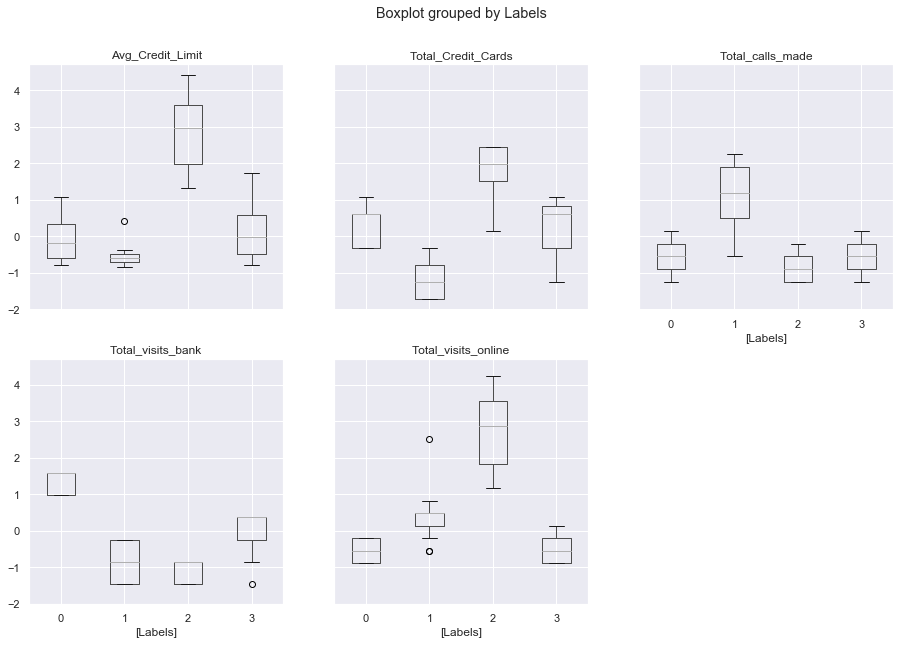

In [15]:
import sklearn
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=0).fit(scaled_df)
df['Labels'] = kmeans.labels_
scaled_df['Labels'] = kmeans.labels_
kmeans_info = df.groupby(['Labels']).mean()
k_box = scaled_df.boxplot(by='Labels', layout = (2,3),figsize=(15,10))
k_box

In [16]:
#Here I compare the means for each column for each created cluster
#It seems that 4 clusters may be too many
#Clusters 0 and 3 for total credit cards seem to have very similar means, indicating that a cluster 
    #may be redundant or not necessary
#Clusters 0 and 2 have similar mean values in the total calls made column as well, possibly suggesting
     #that a cluster is not needed
kmeans_info

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Labels,,,,,
0,31226.315789,5.478947,4.515789,1.010526,1.936842
1,12167.420814,2.393665,0.927602,3.574661,6.923077
2,141040.000000,8.740000,0.600000,10.900000,1.080000
3,35904.522613,5.522613,2.477387,0.969849,2.075377


In [17]:
#Now, I re-run clustering except try only 3 clusters
#These results seem a lot better than before as the means across clusters differ considerably now
kmeans = KMeans(n_clusters=3, random_state=0).fit(scaled_df)
df['Labels'] = kmeans.labels_
scaled_df['Labels'] = kmeans.labels_
kmeans_info = df.groupby(['Labels']).mean()
kmeans_info

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Labels,,,,,
0,31226.315789,5.478947,4.515789,1.010526,1.936842
1,12167.420814,2.393665,0.927602,3.574661,6.923077
2,57016.064257,6.168675,2.100402,2.963855,1.875502


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fac888747d0>,
      dtype=object)

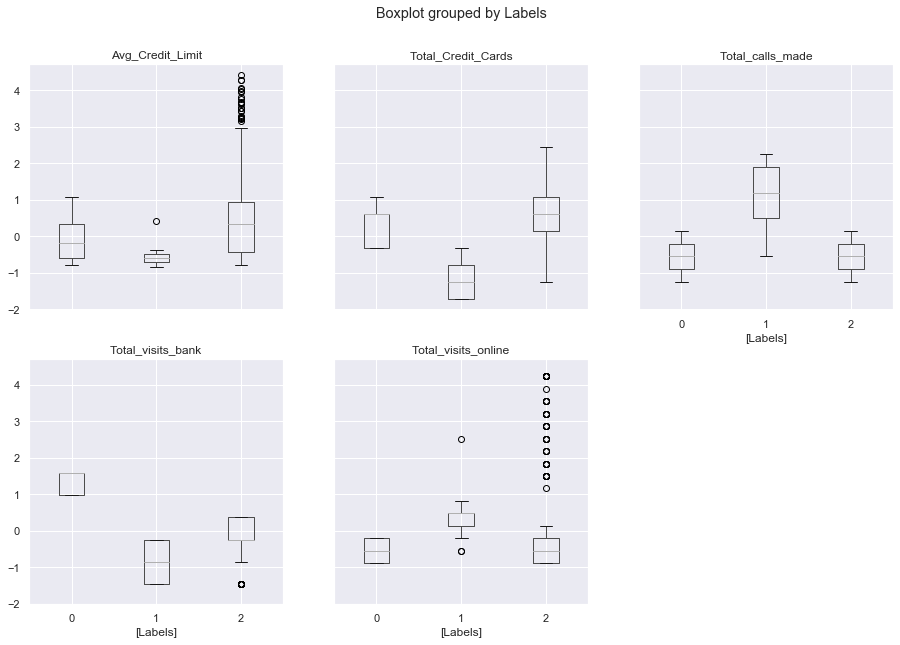

In [18]:
#Now, let us view the clustering results using boxplots 
#As one can clearly see, the means across all groups for each feature of this dataset are quite different
#However, there are a lot of outliers in cluster 2 across some variables
#Hence, it seems like having 4 clusters may be better for this dataset
scaled_df.boxplot(by='Labels', layout = (2,3),figsize=(15,10))

Text(0.5, 1.0, 'Elbow Method Plot')

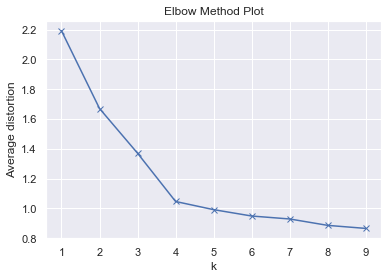

In [19]:
#Now, let us try the elbow method in order to find the optimal number of clusters
#From the plot, it seems that either 4 and 5 clusters are optimal for this dataset
from scipy.spatial.distance import cdist
clusters=range(1,10)
meanDistortions=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(scaled_df)
    prediction=model.predict(scaled_df)
    meanDistortions.append(sum(np.min(cdist(scaled_df, model.cluster_centers_, 'euclidean'), axis=1)) / scaled_df.shape[0])

plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Elbow Method Plot')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fac89d68e90>,
      dtype=object)

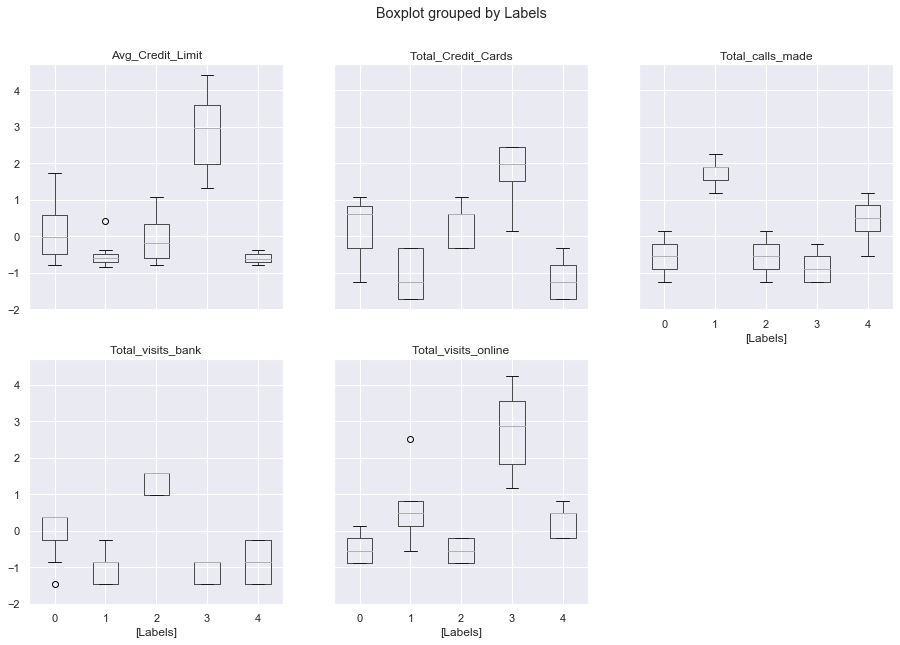

In [20]:
#Let us try picking a higher number in the elbow, 5
#The means of the labels in most variables we see here are quite close to one another
#This means that this could be an excessive number of clusters
kmeans = KMeans(n_clusters=5, random_state=0).fit(scaled_df)
df['Labels'] = kmeans.labels_
scaled_df['Labels'] = kmeans.labels_
kmeans_info = df.groupby(['Labels']).mean()
kmeans_info
scaled_df.boxplot(by='Labels', layout = (2,3),figsize=(15,10))

In [21]:
#The silhouette score for the K-means model with 4 clusters is calculated
#It was found that 0.5411 is the score. This is a mediocre score, indicating that a modest amount of 
    #data points exhibit belongingness in that cluster
#Overall, k-means is doing a somewhat decent job in clustering this data
df = pd.read_excel('Credit Card Customer Data (1).xlsx')
df = df.drop(['Sl_No'], axis=1)
df = df.drop(['Customer Key'], axis=1)
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df),columns=df.columns)
kmeans = KMeans(n_clusters=3, random_state=0).fit(scaled_df)
df['Labels'] = kmeans.labels_
scaled_df['Labels'] = kmeans.labels_
kmeans_info = df.groupby(['Labels']).mean()
silhouette_score(scaled_df,kmeans.labels_)
print('Silhouette Score for K-Means with 3 Clusters:' + str(silhouette_score(scaled_df,kmeans.labels_)))

Silhouette Score for K-Means with 3 Clusters:0.5411228112448502


In [22]:
#I re-run K-means except using 4 clusters and find that the silhouette score is higher for this model
#Hence, I will use 4 clusters across all models for ease of model performance comparison
df = pd.read_excel('Credit Card Customer Data (1).xlsx')
df = df.drop(['Sl_No'], axis=1)
df = df.drop(['Customer Key'], axis=1)
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df),columns=df.columns)
kmeans = KMeans(n_clusters=4, random_state=0).fit(scaled_df)
df['Labels'] = kmeans.labels_
scaled_df['Labels'] = kmeans.labels_
kmeans_info = df.groupby(['Labels']).mean()
silhouette_score(scaled_df,kmeans.labels_)
print('Silhouette Score for K-Means with 4 Clusters:' + str(silhouette_score(scaled_df,kmeans.labels_)))

Silhouette Score for K-Means with 4 Clusters:0.5934324172139464


 # Hierarchical Clustering

## Average Method

In [23]:
#Now I use agglomerative clustering on this dataset
#I import the data and scale it before clustering
df = pd.read_excel('Credit Card Customer Data (1).xlsx')
df = df.drop(['Sl_No'], axis=1)
df = df.drop(['Customer Key'], axis=1)
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df),columns=df.columns)
#scaled_df
ag_model = AgglomerativeClustering(n_clusters=4, affinity='euclidean',  linkage='average')
ag_model.fit(scaled_df)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='average', memory=None, n_clusters=4)

In [24]:
df['Labels'] = ag_model.labels_
hclust_info = df.groupby(['Labels'])
hclust_info.mean()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Labels,,,,,
0,12197.309417,2.403587,0.928251,3.560538,6.883408
1,141040.000000,8.740000,0.600000,10.900000,1.080000
2,33541.450777,5.520725,3.492228,0.984456,2.010363
3,100000.000000,2.000000,1.000000,1.000000,0.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fac87518690>,
      dtype=object)

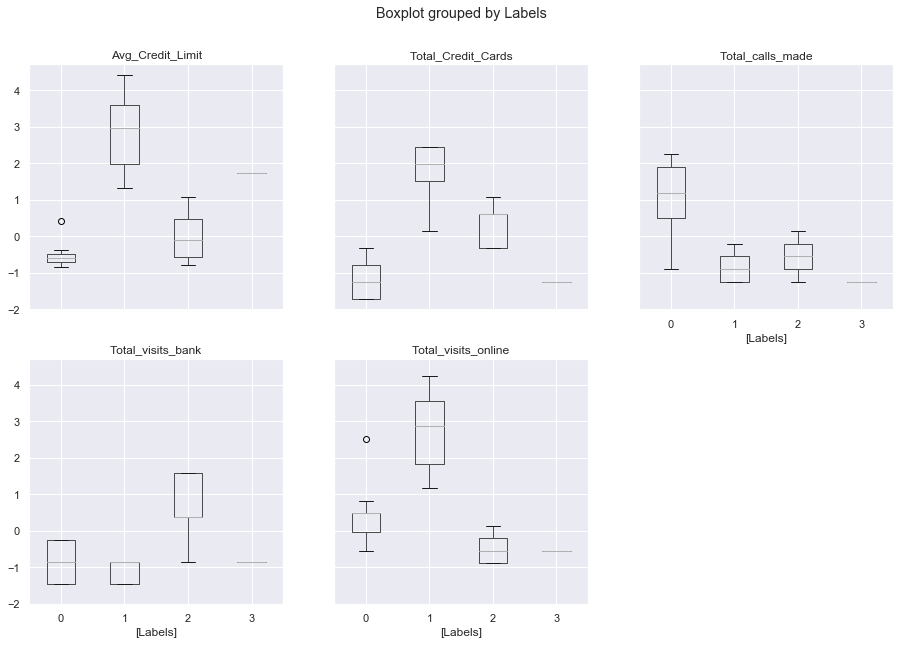

In [25]:
# 4 clusters seem to be working well for this model due to discrepency in cluster means for each feature
scaled_df['Labels'] = ag_model.labels_
ag_model_info = df.groupby(['Labels']).mean()
ag_model_info
avg_box = scaled_df.boxplot(by='Labels', layout = (2,3),figsize=(15,10))
avg_box

In [26]:
#I look more into the exact values of the cluster being generated
#Since the means of each cluster per feature vary from one another significantly, 
    #this supports the argument that 4 clusters is optimal for this dataset
ag_model_info

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Labels,,,,,
0,12197.309417,2.403587,0.928251,3.560538,6.883408
1,141040.000000,8.740000,0.600000,10.900000,1.080000
2,33541.450777,5.520725,3.492228,0.984456,2.010363
3,100000.000000,2.000000,1.000000,1.000000,0.000000


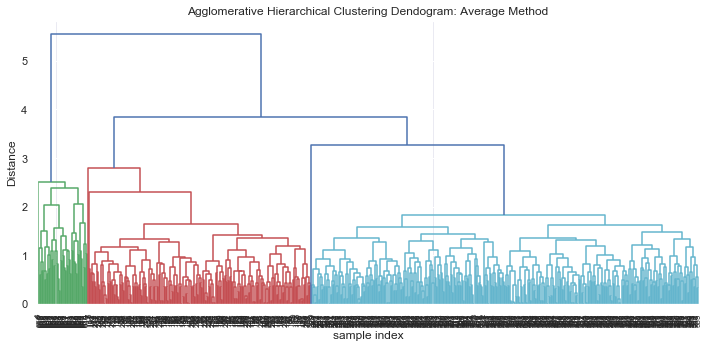

In [27]:
#This is the dendrogram from the average clustering method
#We can clearly see the different clusters formed here, although not very interpretable
x = linkage(scaled_df, 'average', metric = 'euclidean')
plt.figure(figsize=(10, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram: Average Method')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(x, leaf_rotation=90.,color_threshold = 3, leaf_font_size=8., truncate_mode='level' )
plt.tight_layout()

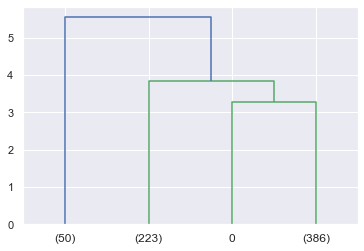

In [28]:
#We are showing only the last 4 merged clusters here
#It seems that the pairwise distances are somewhat small in the average method
#The distances are a lot smaller than that of the Ward's method, which may be contributing 
    #to its high silhouette score
dendrogram(
    x,
    truncate_mode='lastp',  
    p=4,  
)
plt.show()

In [29]:
#The silhouette score is calculated for the agglomerative clustering method using average linking
#This score is higher than that of the k-means method, indicating that this clustering method performs better
silhouette_score(scaled_df,ag_model.labels_)
print('Silhouette Score for Average Method:' + str(silhouette_score(scaled_df,ag_model.labels_)))
c_index, c_dists = cophenet(x, pdist(scaled_df))
print('Cophenet Index for Average Method:' + str(c_index))

Silhouette Score for Average Method:0.5376007389773523
Cophenet Index for Average Method:0.9251915233300487


In [30]:
#Now we explore Ward's linkage method of clustering and its effect on silhouette score and cophenet index

## Ward Method

In [47]:
df = pd.read_excel('Credit Card Customer Data (1).xlsx')
df = df.drop(['Sl_No'], axis=1)
df = df.drop(['Customer Key'], axis=1)
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df),columns=df.columns)
link_mat = linkage(scaled_df, 'ward', metric='euclidean')

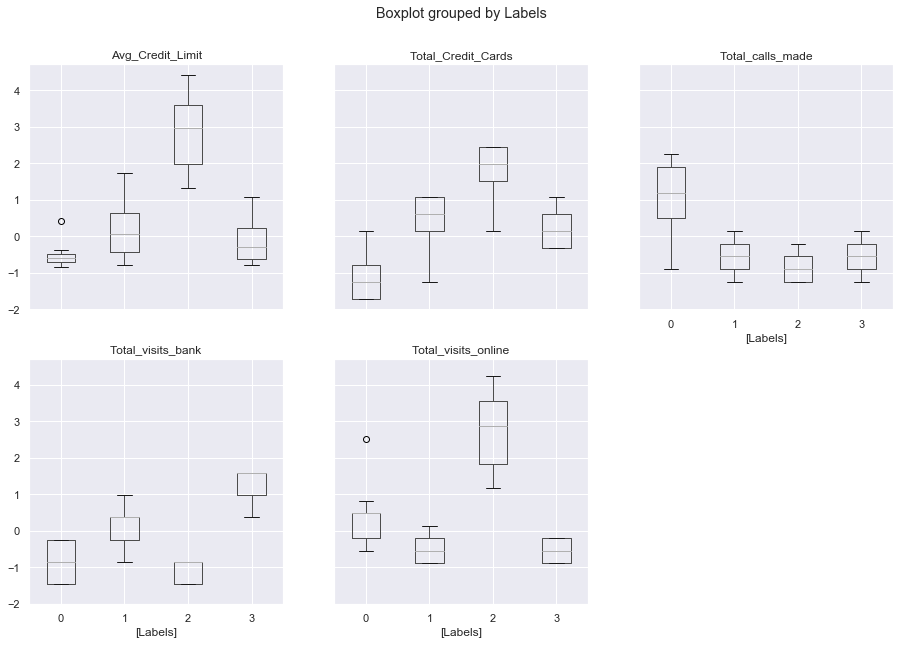

In [48]:
#From the boxplots alone, it seems that Ward's linkage and the average linkage method 
    #yield clusters that offer similar levels of disparity amongst each feature in the dataset
#This is more evidence that this clustering method is not as optimal as we would like it to be
#The boxplots show that the mean values for the clusters per feature are slightly closer to each other,
    #indicating that the belongingess of an object to a particular group may not be very strong

#Now, I will compute silhouette score and cophenet index to compare performance quantitatively
ag_model2 = AgglomerativeClustering(n_clusters=4, affinity='euclidean',  linkage='ward')
ag_model2.fit(scaled_df)
df['Labels'] = ag_model2.labels_
hclust_info = df.groupby(['Labels'])
scaled_df['Labels'] = ag_model2.labels_
ag_model2_info = df.groupby(['Labels']).mean()
ward_box = scaled_df.boxplot(by='Labels', layout = (2,3),figsize=(15,10))
ward_box

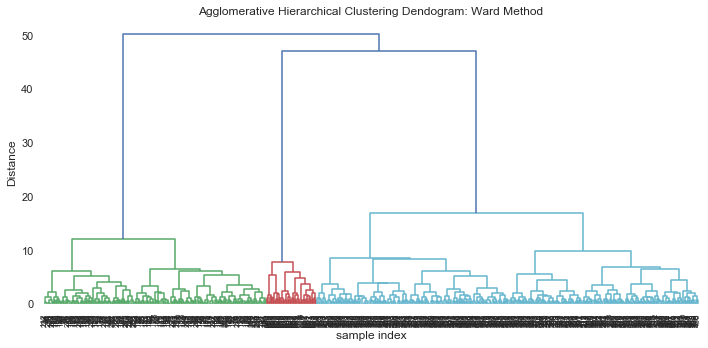

In [33]:
#It seems that more clusters formed have greater distance between points in the Ward's method as 
    #compared to the previous method
plt.figure(figsize=(10, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram: Ward Method')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(link_mat, leaf_rotation=90.,color_threshold = 33, leaf_font_size=8., truncate_mode='level' )
plt.tight_layout()

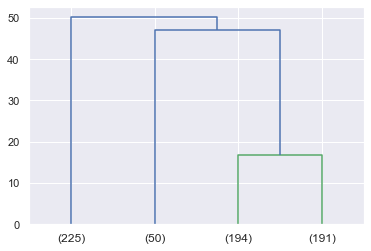

In [42]:
dendrogram(
    link_mat,
    truncate_mode='lastp',  
    p=4,  
)
plt.show()

In [35]:
#Calculating silhouette score for fcluster 
#The silhouette score is approximately the same as the average method
#However, this clustering method seems to be performing worse than the average method since the cophenet index
    #is somewhat lower
silhouette_score(scaled_df,ag_model2.labels_)
print('Silhouette Score for Ward Method:' + str(silhouette_score(scaled_df,ag_model2.labels_)))
c_index, c_dists = cophenet(link_mat, pdist(scaled_df))
print('Cophenet Index for Ward Method:' + str(c_index))

Silhouette Score for Ward Method:0.5081451650507066
Cophenet Index for Ward Method:0.7880754754892926


Insights: Overall, it seems that the average method performs better than Ward's linkage method due to higher silhouette score and cophenet index. However, K-means is performing better than both hierarchical models as its silhouette score is higher than every other models'.

# Comparing Models

How many segments of customers are there?
<br>Insights: From our analysis, it seems that there are 4 segments of customers. From the elbow plot, it was between 3 or 4 clusters. I ended up picking 4 clusters after comparing silhouette scores of the K-mean model using both cluster numbers, respectively. Having 4 clusters in the model boosted the silhouette score by a moderate amount, which lead me to have 4 clusters across all models for ease of performance comparison.

### Kmeans Method Info and Boxplots

In [36]:
kmeans_info

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Labels,,,,,
0,31226.315789,5.478947,4.515789,1.010526,1.936842
1,12167.420814,2.393665,0.927602,3.574661,6.923077
2,141040.000000,8.740000,0.600000,10.900000,1.080000
3,35904.522613,5.522613,2.477387,0.969849,2.075377


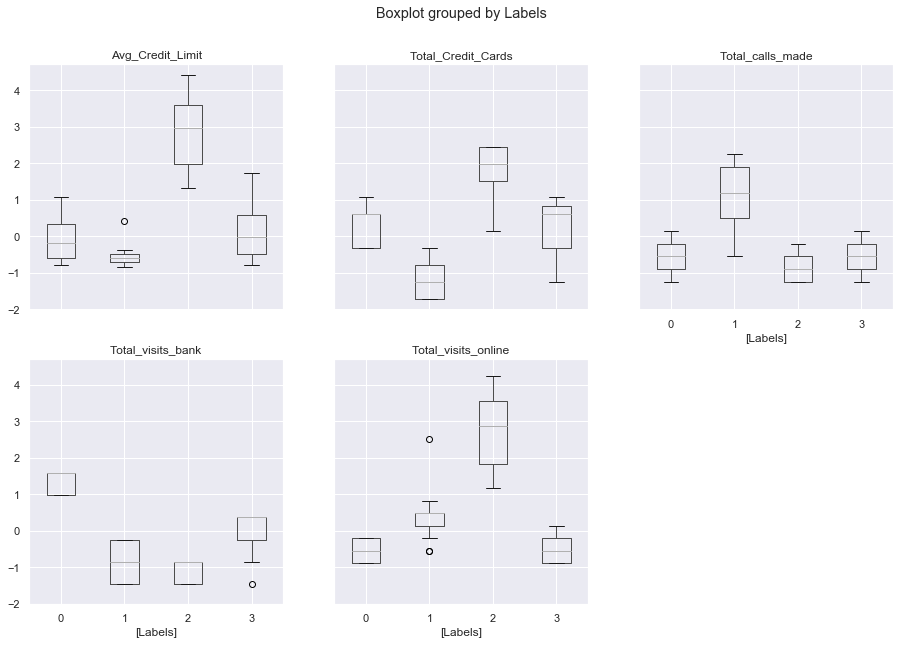

In [54]:
#It seems that the clusters generated by this method are similar to the average method based on the boxplots
#Cluster 3 in this method has more variability as compared to cluster 3 in the average method
#When compared to Wards method as well, the clustes have fairly similar distributions across columns
#The same outliers are present throughout the other two methods, except the kmeans method has two outliers in
    #cluster 1 for the total visits online wherease other methods have only 1
scaled_df['Labels'] = kmeans.labels_
k_box = scaled_df.boxplot(by='Labels', layout = (2,3),figsize=(15,10))

### Average Method Info and Boxplots

In [38]:
ag_model_info

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Labels,,,,,
0,12197.309417,2.403587,0.928251,3.560538,6.883408
1,141040.000000,8.740000,0.600000,10.900000,1.080000
2,33541.450777,5.520725,3.492228,0.984456,2.010363
3,100000.000000,2.000000,1.000000,1.000000,0.000000


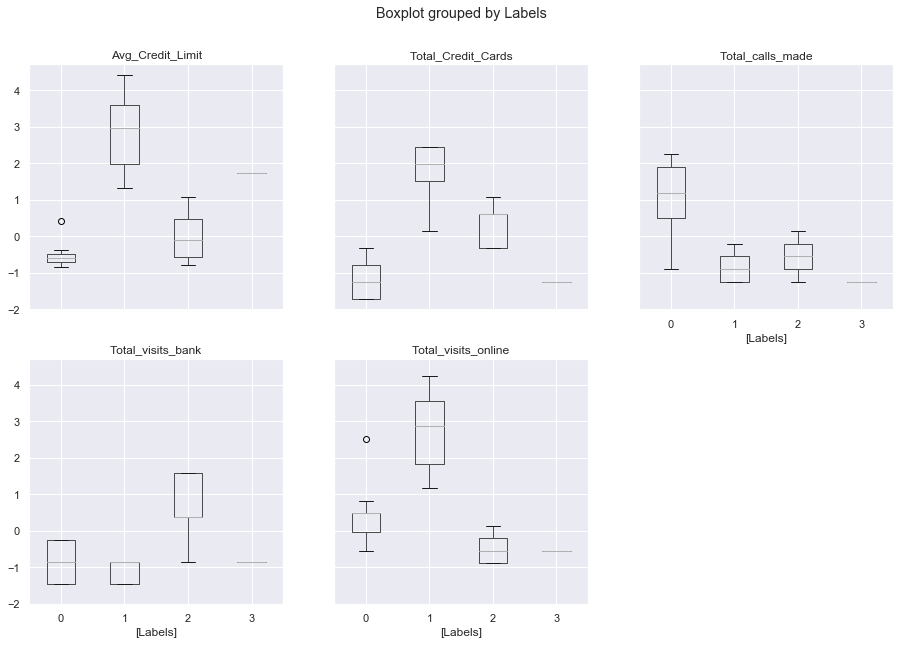

In [53]:
#There seems to be no variability in cluster 3 in this method, which contrasts that of Ward and Kmeans methods
#The clusters seem to mirror that of the Kmeans method except for cluster 3, which seems odd
#It seems that cluster 3 is the lower whisker of the Kmeans method cluster 3 
#Perhaps this means that there is only one value in cluster 3 using the average method, which
    #would not be helpful. Even if this were the case, this model is the better one out of the implemented 
        #hierarchical clustering methods
scaled_df['Labels'] = ag_model.labels_
avg_box = scaled_df.boxplot(by='Labels', layout = (2,3),figsize=(15,10))

### Ward Method Info and Boxplots

In [40]:
ag_model2_info

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Labels,,,,,
0,12151.111111,2.422222,0.937778,3.546667,6.857778
1,38298.429319,5.670157,2.523560,0.947644,2.099476
2,141040.000000,8.740000,0.600000,10.900000,1.080000
3,29474.226804,5.365979,4.448454,1.010309,1.891753


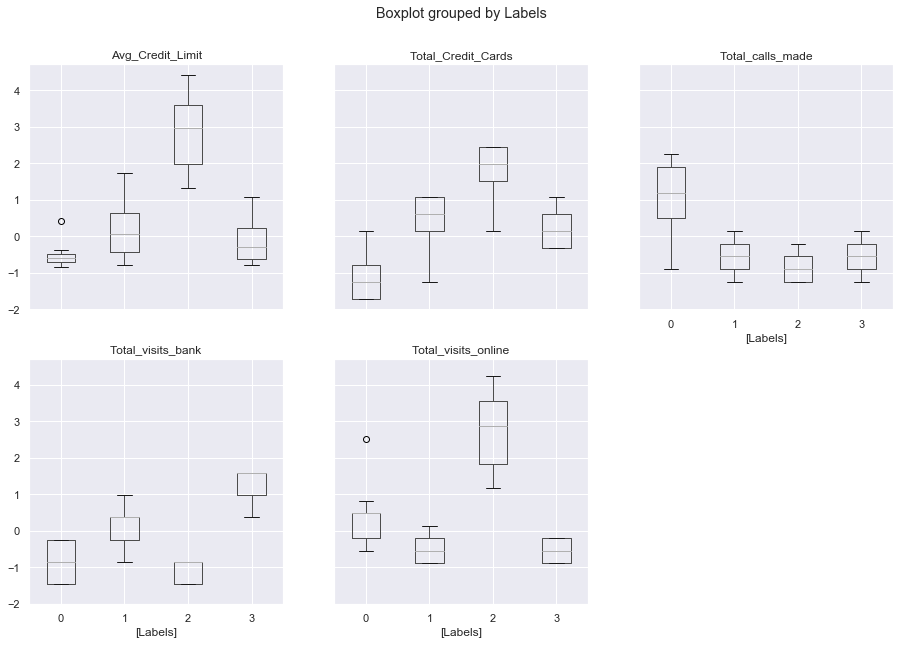

In [52]:
scaled_df['Labels'] = ag_model2.labels_
ward_box = scaled_df.boxplot(by='Labels', layout = (2,3),figsize=(15,10))

Overall, it is hard to tell the difference between clusters for the Kmeans and hierarchical models using only boxplots. Comparing the information tables presented above, it seems that both methods generally have one cluster with high average credit limit, total number of cards, and total visits online. The average method produced a strange cluster that also has very high averagecredit limit with low amounts of every other feature. Kmeans clusters are more similar to those produced by Ward's method across all columns. Although the arrangement of the columns are different, the means per label per column produced are very close to one another.

How does each segment differ from each another?
<br>
Insights: The information above shows information for the kmeans model, the average method clustering, and the Ward's linkage clustering, respectively. There is one segment of customers that seem to have very high average credit limit (around 140000) and number credit cards (around 8) that also visit the online website quite frequently (around 11). Another segment of customers seem to have quite low credit limit (around 12000), low amount of credit cards (around 2), low number of visits to the bank (around 1), moderate amount of visits online (around 4), and a large number of calls made (around 7). The third segment seems to have a slightly higher average credit limit (around 4000), moderate amount of credit cards (around 6), a moderate amount of visits to the bank (around 3), and average 2 calls. The fourth segment is similar to the third segment except the average credit limit is significantly lower by a $1000 or so.

How to better market and service these customers:
<br>
Advice: From my analysis, it seems that a segment of customers are low-risk borrowers of money (the cluster with the very high credit limit). This segment also shows a high number of credit cards, which the bank can make money off of from interest and the customer using this credit card. Since this segment tends to acquire higher number of credit cards and visit the online website, I recommend posting more advertisements on the website to entice the customer in getting more credit cards. This way the bank can upsell to its existing customers that are low-risk users. It also seems that the highest-risk credit card users have the least amount of credit cards. This can be used as a red flag when lending money to customers to be wary. The bank can set lower credit limits to these customers if they wish to dissuade them from spending money that they cannot pay back to the bank. It seems that the high-risk users also tend to make the most calls to the bank. In order to up-sell these customers, the bank can persuade them to purchase more credit cards from them over the phone.